In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import yaml
from train_fno import *
import matplotlib.pyplot as plt
import pickle as pkl
from models.func_to_func2d_invasive import FNO2d
from check_regularity import *


In [2]:
# Load config file
config_name = 'smooth_x_y_grid'
# print CUDA available
print(torch.cuda.is_available())
config_path = 'models/trained_models/' + config_name + '_info.yaml'
with open(config_path, 'r') as file:
    config = yaml.load(file, Loader=yaml.FullLoader)

# Load input and output data
input_data = torch.load('data/smooth_training_data/A_to_chi1_tiny_input_data.pt')
output_data = torch.load('data/smooth_training_data/A_to_chi1_tiny_output_data.pt')

model_name = config['model_name']
N_data = input_data.shape[0]
train_size = config['N_train']
N_modes = config['K']
width  = config['width']
act = config['act']
epochs = config['epochs']
b_size = config['batch_size']
lr = config['lr']
USE_CUDA = config['USE_CUDA']
d_in = config['d_in']
d_out = config['d_out']


False


In [3]:
# Load trained model
model = FNO2d(modes1=N_modes, modes2=N_modes, width=width, d_in=d_in, d_out=d_out, act=act)
model_path = 'models/trained_models/' + model_name + '.pt'
device = torch.device('cuda' if torch.cuda.is_available() and USE_CUDA else 'cpu')
model.load_state_dict(torch.load(model_path, map_location=device)['model_state_dict'])
# model.load_state_dict(torch.load(model_path)['model_state_dict'])
model.eval()


FNO2d(
  (fc0): Linear(in_features=3, out_features=64, bias=True)
  (speconvs): ModuleList(
    (0-3): 4 x SpectralConv2d()
  )
  (ws): ModuleList(
    (0-3): 4 x Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  )
  (mlp0): MLP(
    (fc1): Linear(in_features=64, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=1, bias=True)
  )
)

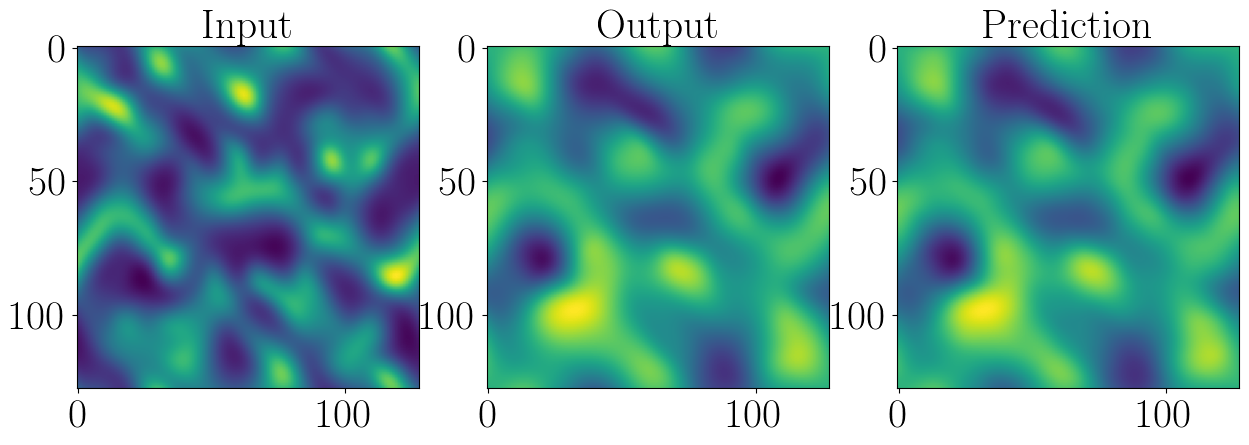

In [4]:
# Plot input and output data
index = 19
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(input_data[index, 0, :, :])
ax[0].set_title('Input')
ax[1].imshow(output_data[index, 0, :, :])
ax[1].set_title('Output')

# Predict output
with torch.no_grad():
    pred = model(input_data[index].unsqueeze(0))

ax[2].imshow(pred[0, 0, :, :])
ax[2].set_title('Prediction')
plt.show()


In [5]:
# Load config file
config_name = 'grad_periodic_grid'
# print CUDA available
print(torch.cuda.is_available())
config_path = 'models/trained_models/' + config_name + '_info.yaml'
with open(config_path, 'r') as file:
    config = yaml.load(file, Loader=yaml.FullLoader)

# Load input and output data
input_data = torch.load('data/grad_training_data/input_data_grad_tiny.pt')
output_data = torch.load('data/grad_training_data/output_data_grad_tiny.pt')

model_name = config['model_name']
N_data = input_data.shape[0]
train_size = config['N_train']
N_modes = config['K']
width  = config['width']
act = config['act']
epochs = config['epochs']
b_size = config['batch_size']
lr = config['lr']
USE_CUDA = config['USE_CUDA']
d_in = config['d_in']
d_out = config['d_out']

False


In [6]:
# Load trained model
model = FNO2d(modes1=N_modes, modes2=N_modes, width=width, d_in=d_in, d_out=d_out, act=act)
model_path = 'models/trained_models/' + model_name + '.pt'
device = torch.device('cuda' if torch.cuda.is_available() and USE_CUDA else 'cpu')
model.load_state_dict(torch.load(model_path, map_location=device)['model_state_dict'])
# model.load_state_dict(torch.load(model_path)['model_state_dict'])
model.eval()

FNO2d(
  (fc0): Linear(in_features=1, out_features=64, bias=True)
  (speconvs): ModuleList(
    (0-3): 4 x SpectralConv2d()
  )
  (ws): ModuleList(
    (0-3): 4 x Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  )
  (mlp0): MLP(
    (fc1): Linear(in_features=64, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=2, bias=True)
  )
)

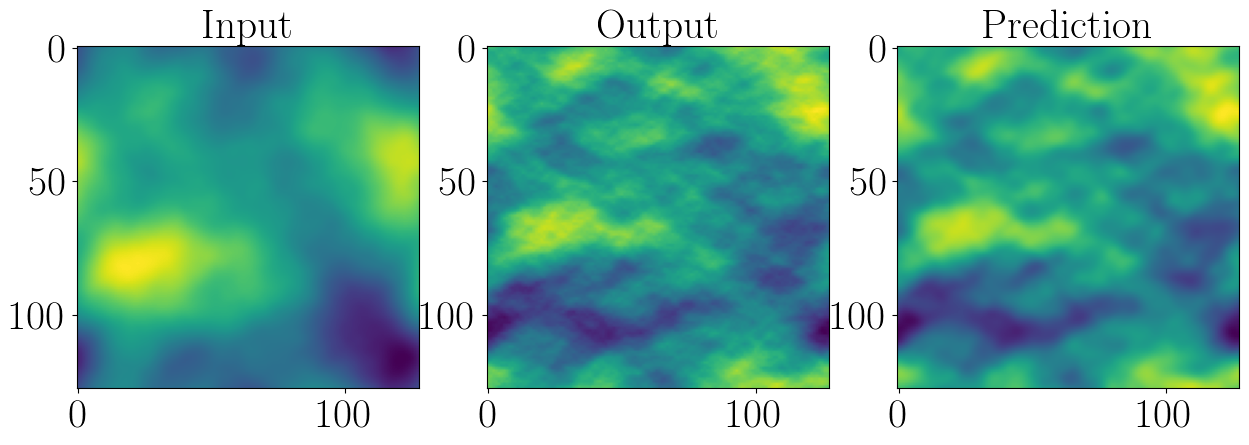

In [7]:
# Plot input and output data
index = 2
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(input_data[index, 0, :, :])
ax[0].set_title('Input')
ax[1].imshow(output_data[index, 0, :, :])
ax[1].set_title('Output')

# Predict output
with torch.no_grad():
    pred = model(input_data[index].unsqueeze(0))

ax[2].imshow(pred[0, 0, :, :])
ax[2].set_title('Prediction')
plt.show()


## Compute regularity of training data

In [8]:
print('Input data shape: ', input_data.shape)

# Check regularity
data_grid = 128
s_s = [0, 1, 2, 3]
data_s = 0
sizes = [32,64,128]
norms = numpy.zeros((len(sizes),len(s_s)))
index = 2
for size_i, size in enumerate(sizes):
    xs, ys = numpy.meshgrid(numpy.linspace(0,1-1/size,size), numpy.linspace(0,1-1/size,size))
    xs = torch.from_numpy(xs)
    ys = torch.from_numpy(ys)
    Z = input_data[index].unsqueeze(0)
    sub = data_grid//size
    Z_sub = Z[:,:,::sub, ::sub]
    for s_i, s in enumerate(s_s):
        norm = Hs_norm(Z_sub,s)
        # to numpy
        norm = norm.detach().numpy()
        norms[size_i,s_i] = norm

plot_norms(sizes, s_s, norms, data_s)

Input data shape:  torch.Size([20, 3, 128, 128])
Max term:  tensor(1.8212e+11, dtype=torch.float64)
Min term:  tensor(19.1252, dtype=torch.float64)


<Figure size 1000x1000 with 0 Axes>

In [9]:
# Check max and min values of the data
print('Max value of input data: ', torch.max(input_data))
print('Min value of input data: ', torch.min(input_data))

Max value of input data:  tensor(2.6608)
Min value of input data:  tensor(-1.1099)
